# Short and Long Term Video Memorability
### MediaEval 2018

**Code Flow**

This code was run on Google Colab environment. 

1.   Shared data folder 'CA684_Assignment_Data' was saved in my local drive and mounted at '/content/drive/'

2.   Base path has been set to '/content/drive/My Drive/CA684_Assignment_Data'

3.   Stopwords were downloaded from nltk package. Also pyprind packages was installed (!pip install pyprind)

4.   All required packages are imported and required functions are defined

5.   Data are preprocessed and made ready for feeding into model

6.   As mentioned in the paper (Section 3.2), I make three different models with different set of input features and evaluated the performance of these predictive models

In [95]:
# Mounting My Drive

from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Set the base path of the  'CA684_Assignment_Data' folder**

In [0]:
basePath = '/content/drive/My Drive/CA684_Assignment_Data'

**Need to download nltk stopwords package**

In [97]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

**Installing progress tracker**

In [98]:
!pip install pyprind

In [0]:
# Importing all required packages

import numpy as np
import pandas as pd
import pyprind
import seaborn as sns
from string import punctuation
from nltk.corpus import stopwords
from textblob import TextBlob
from collections import Counter
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from keras.models import Model, Sequential
from keras import preprocessing, regularizers, backend as K
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Dense, Lambda, LSTM, Embedding, Flatten, Dropout, concatenate

# for reproducability
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(1) 

In [0]:
# define all functions required

def Get_score(Y_pred,Y_true):
    '''Calculate the Spearmann"s correlation coefficient'''
    Y_pred = np.squeeze(Y_pred)
    Y_true = np.squeeze(Y_true)
    if Y_pred.shape != Y_true.shape:
        print('Input shapes don\'t match!')
    else:
        if len(Y_pred.shape) == 1:
            Res = pd.DataFrame({'Y_true':Y_true,'Y_pred':Y_pred})
            score_mat = Res[['Y_true','Y_pred']].corr(method='spearman',min_periods=1)
            print('The Spearman\'s correlation coefficient is: %.3f' % score_mat.iloc[1][0])
        else:
            for ii in range(Y_pred.shape[1]):
                Get_score(Y_pred[:,ii],Y_true[:,ii])

def vname2ID(vnames):
    """Parse video digital id from its name
    vnames: a list contains file names"""
    vid = [ os.path.splitext(vn)[0][5:] for vn in vnames]
    return vid

def read_C3D(fname):
    """Scan vectors from file"""
    with open(fname) as f:
        for line in f:
            C3D =[float(item) for item in line.split()] # convert to float type, using default separator
    return C3D

def read_HMP(fname):
    """Scan HMP(Histogram of Motion Patterns) features from file"""
    with open(fname) as f:
        for line in f:
            pairs=line.split()
            HMP_temp = { int(p.split(':')[0]) : float(p.split(':')[1]) for p in pairs}
    # there are 6075 bins, fill zeros
    HMP = np.zeros(6075)
    for idx in HMP_temp.keys():
        HMP[idx-1] = HMP_temp[idx]            
    return HMP

def read_ColorHistogram(fname):
    """Scan Color Histogram from file
    Input file contains RGB histogram,
    Return a matrix of (3,256)"""
    RGB_Hist = np.zeros((3,256))
    with open(fname) as f:
        i_l = 0 # line index
        for line in f:
            pairs = line.split()
            hist_dict = {int(p.split(':')[0]):float(p.split(':')[1]) for p in pairs}
            for idx in hist_dict.keys():
                RGB_Hist[i_l,idx] = hist_dict[idx]
            i_l += 1
    return RGB_Hist

def read_HOG(fname):
    """Scan vectors from file"""
    with open(fname) as f:
        for line in f:
            HOG =[float(item) for item in line.split()] # convert to float type, using default separator
    return HOG

def read_caps(fname):
    """Load the captions into a dataframe"""
    vn = []
    cap = []
    df = pd.DataFrame();
    with open(fname) as f:
        for line in f:
            pairs = line.split()
            vn.append(pairs[0])
            cap.append(pairs[1])
        df['video']=vn
        df['caption']=cap
    return df

def getOtherFeatures(df_cap_train):
    df_cap_train['sentimentScore'] = df_cap_train['caption'].apply(lambda x: TextBlob(x).sentiment[0])
    df_cap_train['wordCount'] = df_cap_train['caption'].apply(lambda x: len(x.split(' ')))
    stop = set(stopwords.words('english'))
    df_cap_train['capWthoutStopwrds'] = df_cap_train['caption'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
    return df_cap_train

def getVideoFileNames(fname):
    videoFileNames = []
    with open(fname) as f:
      for line in f:
        pairs=line.split()
        videoFileNames.append(pairs[0][:-5])
    return videoFileNames

**Loading and processing caption data**

In [101]:
# load the captions from dev-set
cap_path = basePath + '/dev-set/dev-set_video-captions.txt'
df_cap_train=read_caps(cap_path)
print('Shape of train data: ',df_cap_train.shape)

# load the captions from test-set
cap_path = basePath + '/test-set/test-set-1_video-captions.txt'
df_cap_test=read_caps(cap_path)
print('Shape of test data: ',df_cap_test.shape)

df_cap = pd.concat([df_cap_train,df_cap_test],ignore_index=True)
print('shape after concatenation',df_cap.shape)

# load the ground truth values from dev-set
labels=pd.read_csv(basePath+'/dev-set/dev-set_ground-truth.csv')

counts = Counter()
# setup prograss tracker
pbar = pyprind.ProgBar(len(df_cap['caption']), title='Counting word occurrences')
for i, cap in enumerate(df_cap['caption']):
    # replacing all punctuations with spaces
    # converting words to lower case
    text = ''.join([c if c not in punctuation else ' ' for c in cap]).lower()
    df_cap.loc[i,'caption'] = text
    pbar.update()
    counts.update(text.split())
    
df_cap.head()

Counting word occurrences


Shape of train data:  (6000, 2)
Shape of test data:  (2000, 2)
shape after concatenation (8000, 2)


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:06


,video,caption
0,video3.webm,blonde woman is massaged tilt down
1,video4.webm,roulette table spinning with ball in closeup shot
2,video6.webm,khr gangsters
3,video8.webm,medical helicopter hovers at airport
4,video10.webm,couple relaxing on picnic crane shot


In [102]:
counts = Counter()
# setup prograss tracker
pbar = pyprind.ProgBar(len(df_cap_test['caption']), title='Counting word occurrences')
for i, cap in enumerate(df_cap_test['caption']):
    text = ''.join([c if c not in punctuation else ' ' for c in cap]).lower()
    df_cap_test.loc[i,'caption'] = text
    pbar.update()
    counts.update(text.split())
    
df_cap_test.head()

Counting word occurrences
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00


,video,caption
0,video7494.webm,green jeep struggling to drive over huge rocks
1,video7495.webm,hiking woman tourist is walking forward in mou...
2,video7496.webm,close up of african american doctors hands usi...
3,video7497.webm,slow motion of a man using treadmill in the gy...
4,video7498.webm,slow motion of photographer in national park


In [103]:
# For Test Data
df_cap_test['caption'] = df_cap_test['caption'].map(lambda x: x.replace('-', ' '))
df_cap_test['caption'] = df_cap_test['caption'].str.lower()
caption_test_sent_df = getOtherFeatures(df_cap_test)

sentiment_test_data = caption_test_sent_df.sentimentScore.values
sentiment_test_data = np.around(sentiment_test_data, 2)

word_count_test_data = caption_test_sent_df.wordCount.values

# For Train Data
df_cap_train['caption'] = df_cap_train['caption'].map(lambda x: x.replace('-', ' '))
df_cap_train['caption'] = df_cap_train['caption'].str.lower()
caption_sent_df = getOtherFeatures(df_cap_train)

sentiment_data = caption_sent_df.sentimentScore.values
sentiment_data = np.around(sentiment_data, 2)

word_count_data = caption_sent_df.wordCount.values

print(sentiment_data.shape, word_count_data.shape)

(6000,) (6000,)


In [0]:
seqLen=np.zeros(len(df_cap))
for c in range(len(df_cap)):
  text = df_cap.caption[c]
  seqLen[c]=len(text.split())

maxlen = int(max(seqLen))

# Making word tokens
len_token = len(counts)
tokenizer = Tokenizer(num_words=len_token)
tokenizer.fit_on_texts(list(df_cap.caption.values))
sequences = tokenizer.texts_to_sequences(list(df_cap_train.capWthoutStopwrds.values))

X_seq = preprocessing.sequence.pad_sequences(sequences,maxlen=maxlen)
test_sequences = tokenizer.texts_to_sequences(list(df_cap_test.caption.values))
X_test = preprocessing.sequence.pad_sequences(test_sequences,maxlen=maxlen)

Y = labels[['short-term_memorability','long-term_memorability']].values
X = X_seq
X_all = np.concatenate([X,X_test])


X_train = X[0:5000]
X_val = X[5000:]
Y_train = Y[0:5000]
Y_val = Y[5000:]

# split data into train and validation
sentiment_data_train = sentiment_data[0:5000]
sentiment_data_val = sentiment_data[5000:]

word_count_data_train = word_count_data[0:5000]
word_count_data_val = word_count_data[5000:]


**Correlation between short term and long term memorability**

Text(0.5, 1.0, 'Pearson Correlation: 0.325')

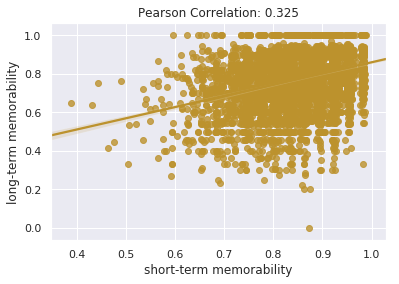

In [105]:
sns.set(color_codes=True)
fig=sns.regplot(x='short-term_memorability', y="long-term_memorability", data=labels, color='#bc922d');
fig.axes.set_xlabel('short-term memorability')
fig.axes.set_ylabel('long-term memorability')
fig.axes.set_title('Pearson Correlation: %.3f' % np.corrcoef(Y.T)[0,1])

**Correlation between short term memorability and absolute sentiment scores**

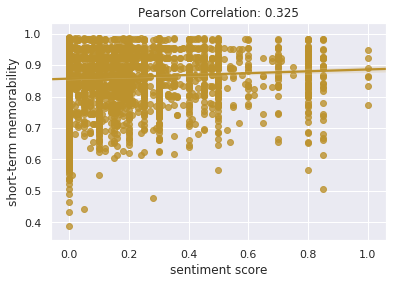

In [106]:
sentiment_data_abs = np.abs(sentiment_data)
sns.set(color_codes=True)
df = pd.DataFrame({'x':sentiment_data_abs, 'y':labels['short-term_memorability'].values})

fig=sns.regplot(x='x', y="y", data=df, color='#bc922d');
fig.axes.set_xlabel('sentiment score')
fig.axes.set_ylabel('short-term memorability')
fig.axes.set_title('Pearson Correlation: %.3f' % np.corrcoef(Y.T)[0,1])
plt.savefig('SentimentVsShortMem.eps')

**Correlation between long term memorability and absolute sentiment scores**

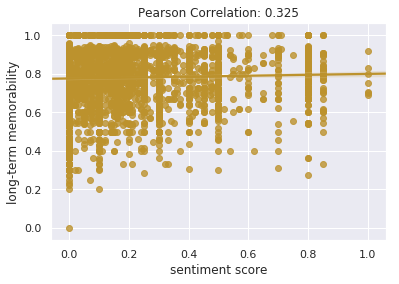

In [107]:
sentiment_data_abs = np.abs(sentiment_data)
sns.set(color_codes=True)
df = pd.DataFrame({'x':sentiment_data_abs, 'y':labels['long-term_memorability'].values})

fig=sns.regplot(x='x', y="y", data=df, color='#bc922d');
fig.axes.set_xlabel('sentiment score')
fig.axes.set_ylabel('long-term memorability')
fig.axes.set_title('Pearson Correlation: %.3f' % np.corrcoef(Y.T)[0,1])
plt.savefig('SentimentVsLongMem.eps')

**Building Model with Caption and Sentiment features**

In [108]:
# Building the model using Keras Functional API

caption_input = Input(shape=(maxlen,), dtype='int32', name='caption_input')
sentiment_input = Input(shape=(1,), name='sentiment_input')

x = Embedding(1+X_all.max(),15,input_length=maxlen)(caption_input)
x = LSTM(32)(x)
x = concatenate([x, sentiment_input])
x = Dense(10,activation='relu',kernel_regularizer=regularizers.l1_l2(l1=0.001,l2=0.004))(x)
out = Dense(2,activation='sigmoid')(x)

model = Model(inputs=[caption_input, sentiment_input], outputs=out)
model.compile(optimizer='rmsprop',loss='mae',metrics=['acc'])

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
caption_input (InputLayer)      (None, 37)           0                                            
__________________________________________________________________________________________________
embedding_5 (Embedding)         (None, 37, 15)       47955       caption_input[0][0]              
__________________________________________________________________________________________________
lstm_5 (LSTM)                   (None, 32)           6144        embedding_5[0][0]                
__________________________________________________________________________________________________
sentiment_input (InputLayer)    (None, 1)            0                                            
__________________________________________________________________________________________________
concatenat

In [52]:
# Model Training

history = model.fit([X_train, sentiment_data_train],
                    Y_train,epochs=50,batch_size=32,
                    validation_data=([X_val, sentiment_data_val], Y_val))

Train on 5000 samples, validate on 1000 samples
Epoch 1/50
5000/5000 [==============================] - 11s 2ms/step - loss: 0.1741 - acc: 0.7006 - val_loss: 0.1313 - val_acc: 0.7090
Epoch 2/50
5000/5000 [==============================] - 10s 2ms/step - loss: 0.1118 - acc: 0.7040 - val_loss: 0.1012 - val_acc: 0.7090
Epoch 3/50
5000/5000 [==============================] - 10s 2ms/step - loss: 0.0950 - acc: 0.7040 - val_loss: 0.0956 - val_acc: 0.7090
Epoch 4/50
5000/5000 [==============================] - 10s 2ms/step - loss: 0.0893 - acc: 0.7040 - val_loss: 0.0920 - val_acc: 0.7090
Epoch 5/50
5000/5000 [==============================] - 12s 2ms/step - loss: 0.0858 - acc: 0.7040 - val_loss: 0.0904 - val_acc: 0.7090
Epoch 6/50
5000/5000 [==============================] - 11s 2ms/step - loss: 0.0832 - acc: 0.7040 - val_loss: 0.0899 - val_acc: 0.7090
Epoch 7/50
5000/5000 [==============================] - 11s 2ms/step - loss: 0.0811 - acc: 0.7040 - val_loss: 0.0911 - val_acc: 0.7090
Epoch 8

**Change in Loss and Accuracy over 50 epochs **

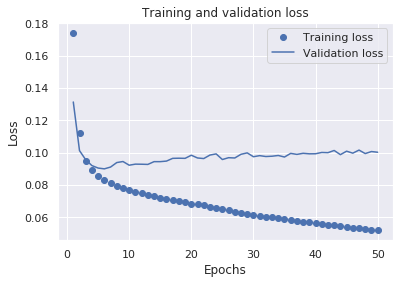

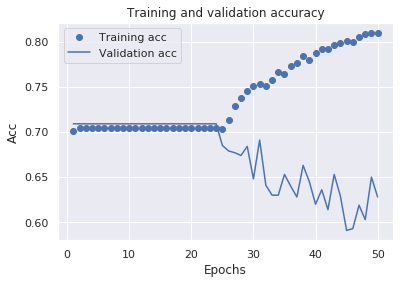

In [53]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1,len(loss)+1)

plt.plot(epochs,loss,'bo',label='Training loss')
plt.plot(epochs,val_loss,'b',label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


plt.figure()
acc = history.history['acc']
val_acc = history.history['val_acc']
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()
plt.show()

**Getting Spearman's Correlation Scores**

In [54]:
# Get the prediction on train and validation data
Y_pred_train = model.predict([X_train, sentiment_data_train])
Y_pred_val = model.predict([X_val, sentiment_data_val])

# Get the Spearman correlation scores for train and validation data
print('='*20)
print('Training Scores')
Get_score(Y_pred_train,Y_train)
print('='*20)
print('Evaluation Scores')
Get_score(Y_pred_val,Y_val)

Training Scores
The Spearman's correlation coefficient is: 0.734
The Spearman's correlation coefficient is: 0.780
Evaluation Scores
The Spearman's correlation coefficient is: 0.390
The Spearman's correlation coefficient is: 0.135


**Get the prediction on test data**

In [0]:
# Get the prediction on unseen test data
Y_pred_test = model.predict([X_test, sentiment_test_data])
Y_pred_test = np.around(Y_pred_test, 3)

np.savetxt("/content/Test_Pred.csv", Y_pred_test, delimiter=",", fmt='%0.3f')

**Building Model with Caption, Sentiment and Words-Count features**



In [72]:
# Building the model using Keras Functional API

caption_input = Input(shape=(maxlen,), dtype='int32', name='caption_input')
sentiment_input = Input(shape=(1,), name='sentiment_input')
word_count_input = Input(shape=(1,), name='word_count_input')

x = Embedding(1+X_all.max(),15,input_length=maxlen)(caption_input)
x = LSTM(32)(x)
x = concatenate([x, sentiment_input, word_count_input])
x = Dense(10,activation='relu',kernel_regularizer=regularizers.l1_l2(l1=0.001,l2=0.004))(x)
out = Dense(2,activation='sigmoid')(x)

model = Model(inputs=[caption_input, sentiment_input, word_count_input], outputs=out)
model.compile(optimizer='rmsprop',loss='mae',metrics=['acc'])

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
caption_input (InputLayer)      (None, 37)           0                                            
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 37, 15)       88050       caption_input[0][0]              
__________________________________________________________________________________________________
lstm_4 (LSTM)                   (None, 32)           6144        embedding_4[0][0]                
__________________________________________________________________________________________________
sentiment_input (InputLayer)    (None, 1)            0                                            
__________________________________________________________________________________________________
word_count

In [73]:
# Model Training
history = model.fit([X_train, sentiment_data_train, word_count_data_train],
                    Y_train,epochs=50,batch_size=32,
                    validation_data=([X_val, sentiment_data_val, word_count_data_val], Y_val))

Train on 5000 samples, validate on 1000 samples
Epoch 1/50
5000/5000 [==============================] - 12s 2ms/step - loss: 0.3824 - acc: 0.3942 - val_loss: 0.3151 - val_acc: 0.2910
Epoch 2/50
5000/5000 [==============================] - 11s 2ms/step - loss: 0.2818 - acc: 0.6894 - val_loss: 0.2489 - val_acc: 0.7090
Epoch 3/50
5000/5000 [==============================] - 11s 2ms/step - loss: 0.1301 - acc: 0.7036 - val_loss: 0.0919 - val_acc: 0.7090
Epoch 4/50
5000/5000 [==============================] - 10s 2ms/step - loss: 0.0905 - acc: 0.7040 - val_loss: 0.0923 - val_acc: 0.7090
Epoch 5/50
5000/5000 [==============================] - 10s 2ms/step - loss: 0.0902 - acc: 0.7040 - val_loss: 0.0958 - val_acc: 0.7090
Epoch 6/50
5000/5000 [==============================] - 10s 2ms/step - loss: 0.0897 - acc: 0.7040 - val_loss: 0.0911 - val_acc: 0.7090
Epoch 7/50
5000/5000 [==============================] - 10s 2ms/step - loss: 0.0874 - acc: 0.7040 - val_loss: 0.0891 - val_acc: 0.7090
Epoch 8

/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.120396). Check your callbacks.
  % delta_t_median)


5000/5000 [==============================] - 10s 2ms/step - loss: 0.0689 - acc: 0.7040 - val_loss: 0.0946 - val_acc: 0.7090
Epoch 30/50
5000/5000 [==============================] - 10s 2ms/step - loss: 0.0685 - acc: 0.7040 - val_loss: 0.0944 - val_acc: 0.7090
Epoch 31/50
5000/5000 [==============================] - 10s 2ms/step - loss: 0.0680 - acc: 0.7040 - val_loss: 0.0957 - val_acc: 0.7090
Epoch 32/50
5000/5000 [==============================] - 12s 2ms/step - loss: 0.0676 - acc: 0.7040 - val_loss: 0.0956 - val_acc: 0.7090
Epoch 33/50
5000/5000 [==============================] - 11s 2ms/step - loss: 0.0674 - acc: 0.7040 - val_loss: 0.0961 - val_acc: 0.7090
Epoch 34/50
5000/5000 [==============================] - 10s 2ms/step - loss: 0.0670 - acc: 0.7040 - val_loss: 0.0962 - val_acc: 0.7090
Epoch 35/50
5000/5000 [==============================] - 10s 2ms/step - loss: 0.0667 - acc: 0.7040 - val_loss: 0.0960 - val_acc: 0.7090
Epoch 36/50
5000/5000 [==============================] - 10s

**Change in Loss and Accuracy over 50 epochs**

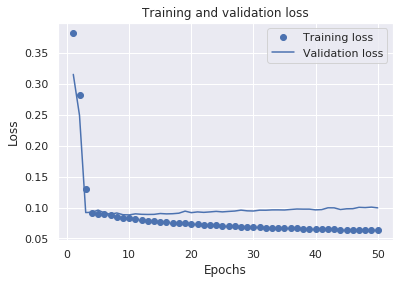

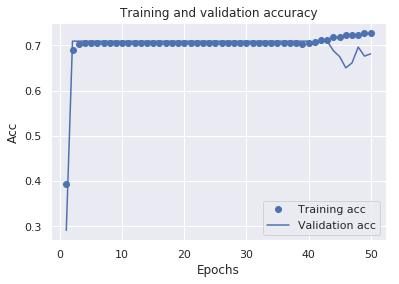

In [74]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1,len(loss)+1)

plt.plot(epochs,loss,'bo',label='Training loss')
plt.plot(epochs,val_loss,'b',label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


plt.figure()
acc = history.history['acc']
val_acc = history.history['val_acc']
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()
plt.show()

**Getting Spearman's Correlation Scores**

In [76]:
# Get the prediction
Y_pred_train = model.predict([X_train, sentiment_data_train, word_count_data_train])
Y_pred_val = model.predict([X_val, sentiment_data_val, word_count_data_val])

# Get the Spearman correlation scores for train and validation data
print('='*20)
print('Training Scores')
Get_score(Y_pred_train,Y_train)
print('='*20)
print('Evaluation Scores')
Get_score(Y_pred_val,Y_val)

Training Scores
The Spearman's correlation coefficient is: 0.413
The Spearman's correlation coefficient is: 0.743
Evaluation Scores
The Spearman's correlation coefficient is: 0.234
The Spearman's correlation coefficient is: 0.148


**Building Model with visual features like C3D/HMP**

In [0]:
# Processing other visual features

videoFileNames = getVideoFileNames(basePath +'/dev-set/dev-set_video-captions.txt')

# initialize arrays for features
c3d_data = np.empty((0,101), int)
color_hist_data = np.empty((0,3,256), int)
hmp_data = np.empty((0,6075), int)

# setup prograss tracker
pbar = pyprind.ProgBar(len(videoFileNames), title='Processing Video File Data')

# load other features
for file in videoFileNames:
  c3d_d           = read_C3D(basePath + '/dev-set/C3D/' + file + '.txt')
  color_hist_d    = read_ColorHistogram(basePath + '/dev-set/ColorHistogram/' + file + '-112.txt')
  hmp_d           = read_HMP(basePath + '/dev-set/HMP/' + file + '.txt')
  c3d_data        = np.append(c3d_data, np.array([c3d_d]), axis=0)
  color_hist_data = np.append(color_hist_data, np.array([color_hist_d]), axis=0)
  hmp_data        = np.append(hmp_data, np.array([hmp_d]), axis=0)
  pbar.update()

# Split of data into train/validation
c3d_data_train = c3d_data[0:5000]
c3d_data_val = c3d_data[5000:]

color_hist_data_train = color_hist_data[0:5000]
color_hist_data_val = color_hist_data[5000:]

hmp_data_train = hmp_data[0:5000]
hmp_data_val = hmp_data[5000:]

In [0]:
# Building the model using Keras Functional API

caption_input = Input(shape=(maxlen,), dtype='int32', name='caption_input')
sentiment_input = Input(shape=(1,), name='sentiment_input')
c3d_input = Input(shape=(101,), name='c3d_input')
hmp_input = Input(shape=(6075,), name='hmp_input')

x = Embedding(1+X_all.max(),15,input_length=maxlen)(caption_input)
x = LSTM(32)(x)
x = concatenate([x, sentiment_input, c3d_input, hmp_input])
x = Dense(10,activation='relu',kernel_regularizer=regularizers.l1_l2(l1=0.001,l2=0.004))(x)
out = Dense(2,activation='sigmoid')(x)

model = Model(inputs=[caption_input, sentiment_input, c3d_input, hmp_input], outputs=out)
model.compile(optimizer='rmsprop',loss='mae',metrics=['acc'])

model.summary()

In [0]:
# Model Training
history = model.fit([X_train, sentiment_data_train, c3d_data_train, hmp_data_train],
                    Y_train,epochs=50,batch_size=32,
                    validation_data=([X_val, sentiment_data_val, word_count_data_val, c3d_data_val, hmp_data_val],
                                     Y_val))

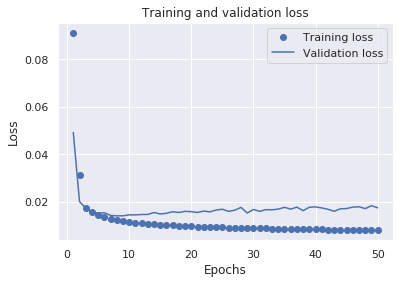

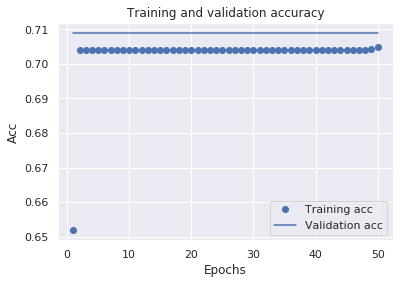

In [37]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1,len(loss)+1)

plt.plot(epochs,loss,'bo',label='Training loss')
plt.plot(epochs,val_loss,'b',label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


plt.figure()
acc = history.history['acc']
val_acc = history.history['val_acc']
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()
plt.show()

**Getting Spearman's Correlation Scores**

In [0]:
# Get the prediction
Y_pred_train = model.predict([X_train, sentiment_data_train, c3d_data_train, hmp_data_train])
Y_pred_val = model.predict([X_val, sentiment_data_val, c3d_data_val, hmp_data_val])

# Get the Spearman correlation scores for train and validation data
print('='*20)
print('Training Scores')
Get_score(Y_pred_train,Y_train)
print('='*20)
print('Evaluation Scores')
Get_score(Y_pred_val,Y_val)